# Another strategy for visualisation : Latent Dirichlet Allocation models

LDA is another way of modelling natural text:

* a topic is a vector of 'associated' weighted words (weights are probablity for a word to be associated to a given topic)

LDA is a way to reduce dimensionality and find the best set of topics (and therefore the best set of words for each topic) that represent the best a set of documents (or loose the less information given a number of topics)

So given a doc, you can compute a signature, its linear combination of topics and say for example a doc is 80% of topic 'money' and 20% of topic 'family'.

 In our kaggle challenge, we could compute signature of both questions and check the distance between signatures to decide if questions are identical.

Here, these tools are used to display the set of topics. Rudely:

* the more distant the circles are, the best separated the topics are and so the best quality the model is
* the bigger the circle, the bigger the importance of the topic in the dataset

In [1]:
# Ugly incantation to make our framework working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='lda_visualisation'
print_alert('You will work on experiment %s' %EXPERIMENT)

prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))

## First steps
* load our best dataset
* Glue informations from newsgroup model
* find the best newsgroup
* get rid of useless informations

In [2]:
# our main tool to add feature
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]

# This will get back the name of the newsgroup with maximum proba for both questions
NEWSGROUP_LABELS=[
    'religion', #0
    'computers', #1
    'forsale', #2
    'vehicles', #3
    'sport', #4
    'science', #5
    'politics', #6
]

def find_best_newsgroup(r):
    probas = [r['proba_'+c+'_question1'] for c in NEWSGROUP_LABELS]
    max_idx_1 = numpy.argsort(probas)[-1]
    max_1 = probas[max_idx_1]
    return (max_1,NEWSGROUP_LABELS[max_idx_1])

def load_lemmatized_newgroups(dataframe):
    # Bootstrap with our last full save
 
    print_warning('Glue lemmatized questions')
    lemmatized_questions = load_global_dataframe('train_lemmatized')
    dataframe['lemmatized_question1'] = lemmatized_questions['question1']
    del lemmatized_questions

    print_warning('Glue newsgroups')
    newsgroup_proba = load_global_dataframe('train_newsgroup_proba') 
    #we get back best newsgroup and its proba for both questions
    print_warning('find best newsgroups')
    add_column_from_columns(newsgroup_proba,'tmp',find_best_newsgroup)
    add_column_from_column(newsgroup_proba,'proba_newsgroup_1','tmp',lambda t: t[0])
    add_column_from_column(newsgroup_proba,'newsgroup_1','tmp',lambda t: t[1])
    dataframe[['proba_newsgroup_1','newsgroup_1']] = newsgroup_proba[['proba_newsgroup_1','newsgroup_1']]
    del newsgroup_proba

    # remove plenty of useless columns : we look only text and maybe 2 probas
    dataframe=dataframe.drop(columns=[c for c in all_numeric_columns(dataframe) if 'newsgroup' not in c])
    return dataframe

In [3]:
train_dataframe = load_or_build_dataframe('Prepare data for training lda visualisation','train_lda_visu',load_lemmatized_newgroups,train_dataframe)


What do we have as textual data ?

In [4]:
ALL_STRING_COLUMNS=[c for c in train_dataframe.columns if train_dataframe.dtypes[c] not in ['int64','float64']]
ALL_NUMERIC_COLUMNS=all_numeric_columns(train_dataframe)
print_section('All string columns')
print_info(str(ALL_STRING_COLUMNS))
print_section('All numeric columns')
print_info(str(ALL_NUMERIC_COLUMNS))


# describe ALL_STRING_COLUMNS takes HOURS... DON'T DO IT !!

# Better to describe one column at a time
train_dataframe[['question1','lemmatized_question1']]


,question1,lemmatized_question1
0,What is the step by step guide to invest in share market in india?,what be the step by step guide to invest in share market in india
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,what be the story of kohinoor koh i noor diamond
2,How can I increase the speed of my internet connection while using a VPN?,how can i increase the speed of my internet connection while use a vpn
3,Why am I mentally very lonely? How can I solve it?,why be i mentally very lonely how can i solve it
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",which one dissolve in water quikly sugar salt methane and carbon di oxide
...,...,...
404285,How many keywords are there in the Racket programming language of the latest version?,how many keyword be there in the racket programme language of the late version
404286,Do you believe there is life after death?,do you believe there be life after death
404287,What is one coin?,what be one coin
404288,"What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?",what be the approx annual cost of live while study in uic chicago for a indian student


## Try to work on the whole dataset

### Build a LDA model with 10 topics

In [5]:
import gensim
from gensim import corpora,models,similarities
import pyLDAvis.gensim

def build_gensim_lda(dataframe,nb_topics):
    start = time.time()
    print_section('Do a LDA (gensim) to find %d topics' % nb_topics)

    print_info('Build dictionary')
    dictionary = corpora.Dictionary(dataframe.str.split())
    print(dictionary)
    print_info('Build corpus')
    corpus = [dictionary.doc2bow(text) for text in dataframe.str.split()]
    print_info('Build tfidf')
    tfidf = models.TfidfModel(corpus)
    transformed_tfidf = tfidf[corpus]
    #lda = models.LdaMulticore(transformed_tfidf,num_topics=10,id2word=dictionary)
    print_info('Build lda')
    lda = gensim.models.ldamodel.LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=nb_topics, 
                random_state=42,
                chunksize=1000,
                per_word_topics=True)
    print_done('Done',top=start)
    return lda,corpus,dictionary

def visu_gensim_lda(lda,corpus,dictionary):
    print_info('Prepare visualisation')
    start=time.time()
    #pyLDAvis.enable_notebook()
    viz_topics = pyLDAvis.gensim.prepare(lda,corpus,dictionary)
    viz=pyLDAvis.display(viz_topics)
    display(viz)
    print_done('General visu ready in',top=start)

Build the LDA and find 10 best topics (quite slow)

In [6]:
# use this for quick experiments
# train = train_dataframe['lemmatized_stopwords_question1'].sample(1000,random_state=42)
train = train_dataframe['lemmatized_question1']
full_lda,full_corpus,full_dictionary = build_gensim_lda(train,10)

Dictionary(57105 unique tokens: ['be', 'by', 'guide', 'in', 'india']...)


What are those 10 best topic ?

In [7]:
full_lda.show_topics()

[(0,
  '0.149*"why" + 0.068*"do" + 0.044*"not" + 0.044*"people" + 0.038*"be" + 0.034*"on" + 0.030*"quora" + 0.026*"so" + 0.021*"question" + 0.017*"much"'),
 (1,
  '0.082*"be" + 0.079*"the" + 0.066*"in" + 0.035*"of" + 0.030*"india" + 0.030*"what" + 0.028*"and" + 0.023*"a" + 0.014*"who" + 0.012*"world"'),
 (2,
  '0.112*"be" + 0.105*"what" + 0.101*"of" + 0.099*"the" + 0.024*"in" + 0.019*"doe" + 0.018*"a" + 0.017*"mean" + 0.014*"some" + 0.013*"life"'),
 (3,
  '0.122*"the" + 0.097*"be" + 0.067*"and" + 0.066*"what" + 0.039*"of" + 0.036*"in" + 0.026*"between" + 0.025*"how" + 0.022*"difference" + 0.020*"a"'),
 (4,
  '0.089*"be" + 0.075*"a" + 0.074*"to" + 0.054*"it" + 0.023*"doe" + 0.022*"what" + 0.018*"for" + 0.018*"have" + 0.017*"like" + 0.016*"in"'),
 (5,
  '0.145*"i" + 0.100*"how" + 0.070*"can" + 0.054*"do" + 0.048*"a" + 0.047*"my" + 0.025*"get" + 0.022*"in" + 0.021*"to" + 0.020*"should"'),
 (6,
  '0.022*"at" + 0.020*"into" + 0.016*"be" + 0.014*"for" + 0.013*"10" + 0.012*"create" + 0.011*"t

### Visualize using PyLDAVis

Quite slow to prepare (several PCAs are done) and quite a complex and rich interface...

In [8]:
visu_gensim_lda(full_lda,full_corpus,full_dictionary)

Looks like the topics we have learned are:
* a generic question involving quora
* a generic question involving india
* a generic question involving John Doe
* generic patterns for questions like 'what is the difference between .. and  ..'

We have now a way to find what kind of questions are in this dataset (which is still interesting), not the subject of the questions...

Issue is the lemmatization we've done was for another study where stop words were processed later.
Here we will focus on true topics in the dataset if we remove the stop words now

Let's get our best list of stop words and suppress them from lemmatized questions

In [9]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def build_remove_stopwords(dataframe):
    add_column_from_column(dataframe,'lemmatized_stopwords_question1','lemmatized_question1',lambda q1: ' '.join([w for w in q1.split() if w not in all_stop_words]))
    return dataframe

nltk_stopwords = set(stopwords.words('english'))
stopwords.words('english')

sk_stopwords = set(ENGLISH_STOP_WORDS)
print_info('There is %d words in nltk stop words' % len(nltk_stopwords))
print_info('There is %d words in sklearn stop words' % len(sk_stopwords))
new_stopwords = [w for w in sk_stopwords if w not in nltk_stopwords]
print_info('There is %d new stop words in sklearn stop words' % len(new_stopwords))

all_stop_words = nltk_stopwords | sk_stopwords
print_info('There is %d words in the union of stop words' % len(all_stop_words))

train_dataframe = load_or_build_dataframe('Training: remove stop words from lemmatized questions','training_lemmatized_stopwords_newsgroup',build_remove_stopwords,train_dataframe)

### Redo a LDA on the whole dataset but on simplified lemmatized questions

In [10]:
# use this for quick experiments
# train = train_dataframe['lemmatized_stopwords_question1'].sample(1000,random_state=42)
train = train_dataframe['lemmatized_stopwords_question1']
full_simplified_lda,full_simplified_corpus,full_simplified_dictionary = build_gensim_lda(train,10)


Dictionary(56817 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)


What are our new 10 best topics ?

In [11]:
full_simplified_lda.show_topics()

[(0,
  '0.048*"people" + 0.045*"doe" + 0.040*"work" + 0.033*"think" + 0.031*"like" + 0.024*"new" + 0.020*"long" + 0.016*"country" + 0.015*"change" + 0.015*"indian"'),
 (1,
  '0.036*"year" + 0.026*"engineer" + 0.020*"book" + 0.017*"student" + 0.016*"old" + 0.015*"computer" + 0.015*"president" + 0.013*"science" + 0.013*"state" + 0.013*"10"'),
 (2,
  '0.050*"make" + 0.034*"money" + 0.032*"thing" + 0.025*"day" + 0.023*"\ufeff1" + 0.020*"good" + 0.018*"business" + 0.016*"online" + 0.016*"black" + 0.014*"movie"'),
 (3,
  '0.055*"way" + 0.027*"learn" + 0.027*"time" + 0.026*"know" + 0.022*"girl" + 0.020*"love" + 0.019*"start" + 0.018*"want" + 0.017*"possible" + 0.016*"company"'),
 (4,
  '0.031*"trump" + 0.025*"lose" + 0.025*"2016" + 0.021*"stop" + 0.021*"weight" + 0.019*"r" + 0.018*"win" + 0.014*"month" + 0.014*"video" + 0.011*"great"'),
 (5,
  '0.067*"doe" + 0.043*"life" + 0.037*"mean" + 0.022*"feel" + 0.017*"compare" + 0.017*"study" + 0.017*"like" + 0.017*"college" + 0.014*"live" + 0.014*"us

In [12]:
visu_gensim_lda(full_simplified_lda,full_simplified_corpus,full_simplified_dictionary)

Better as it is much more focused on topics than syntax

## Focus on newsgroup 'politics'
Maybe the dataset was too big and too various. Let's focus on politics

Also, try to find the best number of topics: just try all numbers of topics and follow a dedicated metric of LDA models: **coherence**

In [13]:
import gensim
from gensim import corpora,models,similarities
from gensim.models import CoherenceModel


def explore_lda(dataframe,focus,tries_nb_topics):
    start=time.time()
    print_section('Find best number of topics')
    print_info('Focus on %s: %d questions' % (focus,len(politics)))

    dictionary = corpora.Dictionary(dataframe.str.split())
    corpus = [dictionary.doc2bow(text) for text in dataframe.str.split()]
    tfidf = models.TfidfModel(corpus)
    transformed_tfidf = tfidf[corpus]
    perplexities = []
    coherence = []
    lda_models = []
    for nb_topics in tqdm(tries_nb_topics):
        start_model=time.time()
        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=nb_topics, 
            random_state=42,
            update_every=1,
            chunksize=1000,
            passes=10,
            per_word_topics=True)
        perplexities.append(lda_model.log_perplexity(corpus))
        lda_models.append(lda_model)
        coherence_lda_model = CoherenceModel(model=lda_model, texts=politics.str.split(), dictionary=dictionary, coherence='c_v')
        print_done('Nb Topics %d Perplexity: %f - Coherence %f' % (nb_topics,lda_model.log_perplexity(corpus),coherence_lda_model.get_coherence()),top=start_model)
        coherence.append(coherence_lda_model.get_coherence())
    print_done('Done',top=start)
    return pandas.DataFrame({'coherence': coherence,'perplexity':perplexities,'lda_model':lda_models},index=tries_nb_topics)


In [14]:
politics = train_dataframe[(train_dataframe['newsgroup_1']=='politics') & (train_dataframe['proba_newsgroup_1']>0.8)]['lemmatized_stopwords_question1']
tries_nb_topics = [3,4,9,10,11,12,13] + list(range(20, 100, 10))
# tries_nb_topics = [3,4,5,6,7,8,9,10,11,12]
res_lda_gensim = explore_lda(politics,'politics',tries_nb_topics)

In [15]:
display(res_lda_gensim.sort_values(by=['coherence','perplexity'],ascending=False)[['coherence','perplexity']])
pandas_to_excel(res_lda_gensim.sort_values(by=['coherence','perplexity'],ascending=False)[['coherence','perplexity']],'lda_gensim_politics_find_nb_topics')


,coherence,perplexity
50,0.561422,-16.105670
40,0.549663,-14.146970
60,0.534296,-18.672340
30,0.530323,-12.351950
70,0.506512,-21.913242
80,0.494169,-25.734670
90,0.490485,-30.024637
20,0.476542,-10.633090
13,0.438333,-8.669048
12,0.420856,-8.206387


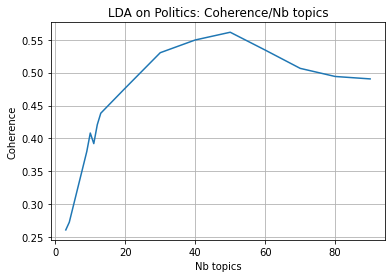

In [16]:
ax = res_lda_gensim['coherence'].plot(title='LDA on Politics: Coherence/Nb topics')
ax.set_xlabel('Nb topics')
ax.set_ylabel('Coherence')
plot.grid(True)
plot_save('lda_gensim_politics_find_nb_topics')


Looks like we need no less than 50 topics to 'cluster' politics ...

In [17]:
best_lda_politics = res_lda_gensim['lda_model'][50]

Display it

In [18]:
best_lda_politics.show_topics()

[(22,
  '0.206*"u" + 0.132*"year" + 0.077*"territory" + 0.054*"possession" + 0.053*"include" + 0.044*"entire" + 0.036*"south" + 0.036*"past" + 0.035*"occupy" + 0.033*"carolina"'),
 (11,
  '0.131*"attack" + 0.106*"indians" + 0.101*"americans" + 0.080*"union" + 0.055*"today" + 0.051*"terrorist" + 0.051*"public" + 0.044*"soviet" + 0.033*"9" + 0.033*"11"'),
 (25,
  '0.126*"police" + 0.125*"army" + 0.098*"officer" + 0.063*"leave" + 0.058*"liberal" + 0.055*"congress" + 0.042*"german" + 0.040*"revolution" + 0.032*"ask" + 0.030*"indian"'),
 (32,
  '0.110*"invade" + 0.098*"democrat" + 0.082*"republicans" + 0.071*"cause" + 0.051*"important" + 0.046*"1" + 0.045*"believe" + 0.040*"main" + 0.032*"global" + 0.026*"build"'),
 (24,
  '0.147*"gun" + 0.092*"allow" + 0.078*"city" + 0.064*"2" + 0.037*"growth" + 0.036*"new" + 0.036*"york" + 0.036*"ireland" + 0.027*"successful" + 0.025*"rank"'),
 (1,
  '0.106*"come" + 0.080*"hitler" + 0.058*"stop" + 0.057*"day" + 0.055*"greece" + 0.052*"race" + 0.048*"europ

A little bit more interesting but

* there is whole set of topics quite near ...
* still difficult to understand


In [19]:
start = time.time()
dictionary = corpora.Dictionary(politics.str.split())
corpus = [dictionary.doc2bow(text) for text in politics.str.split()]
viz_politics_topics = pyLDAvis.gensim.prepare(best_lda_politics,corpus,dictionary)
viz_politics=pyLDAvis.display(viz_politics_topics)
display(viz_politics)
print_done('Politics visu ready in',top=start)

In [20]:
# save it to html format
html_file_name = absolute_env_file_name('visu_politics',ext='.html')
pyLDAvis.save_html(viz_politics_topics,html_file_name)
print_info('Visualisation of politics topics should be available at %s' %html_file_name)

Probably the most easy to understand: a termite graph
* all words for all topics are displayed
* each topic has a color
* a word has the color of its dominant topic
* the circle is proportional to the importance of the word in the topic

2 cons
* termite package no more works independantly than textacy. So we have to redo everything with textacy...
* textacy has a different implementation of LDA with less parameters. Topics are not the same ...

We will also force the limit the # of topics to 10 hoping to make clusters more easy to understand ...

In [21]:
import textacy
import textacy.vsm
import textacy.tm

def textacy_lda_termite(dataframe,nb_topics,subject,visu=False):
        start=time.time()
        print_section('LDA with textacy on %s' % subject)
        print_info('Vectorize all %d questions ' % len(dataframe))
        vectorizer = textacy.vsm.Vectorizer(
                min_df=3, max_df=0.95, max_n_terms=None)
        doc_term_matrix = vectorizer.fit_transform(dataframe.str.split())
        # Build the lda model
        print_info('Build the LDA model on %d topics' % nb_topics)
        model = textacy.tm.TopicModel('lda', n_topics=nb_topics)
        model.fit(doc_term_matrix)
        # get the topics vectors
        print_info('Get all transformed questions')
        doc_topic_matrix = model.transform(doc_term_matrix)
        # extract all weights of words
        topic_weight_serie = pandas.Series(model.topic_weights(doc_topic_matrix))
        # get the most important
        top_list_tmp = topic_weight_serie.nlargest(n=6) # max !
        top_topic_list = list(top_list_tmp.index)
        if visu:
                print_info('Generate the termite graph')
                grid = model.termite_plot(doc_term_matrix, vectorizer.id_to_term, highlight_topics=top_topic_list,
                   topics=-1,  n_terms=30, sort_terms_by='seriation')
                grid.set_title('%d best topics on subject' % nb_topics)
                plot_save('termite_%s' % subject.replace(' ','_'))
                print_done('Done',top=start)
        return model


TopicModel(n_topics=10, model=LatentDirichletAllocation)

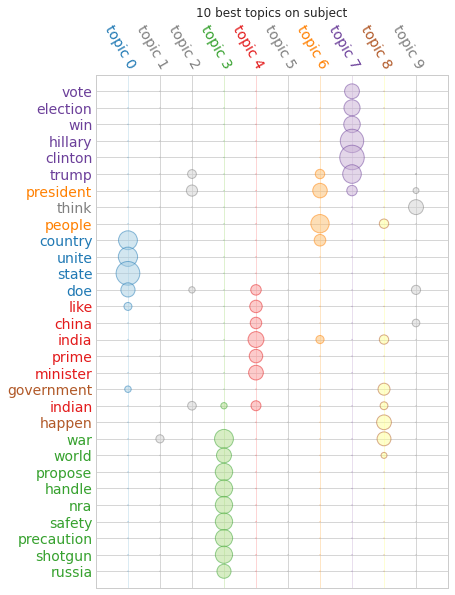

In [22]:
# Note also we should again search the best # of topics ...
textacy_lda_termite(politics,10,'newsgroup politics',visu=True)


Much more interesting (even if the quality of these set of topics is not clear)

What about some other newsgroups : religion, computers, science, sport, vehicles

And try to also to be more strict for newsgroup : use a threshold of 0.9

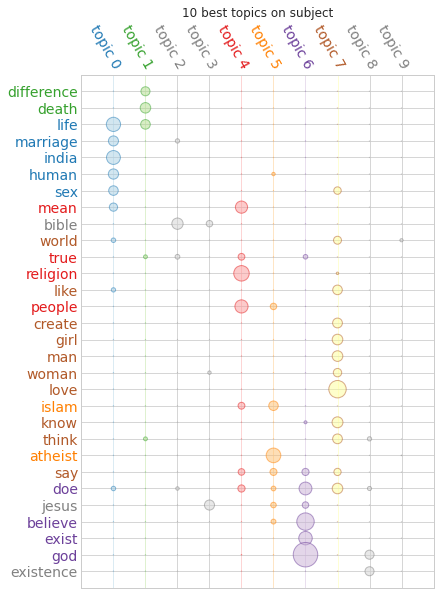

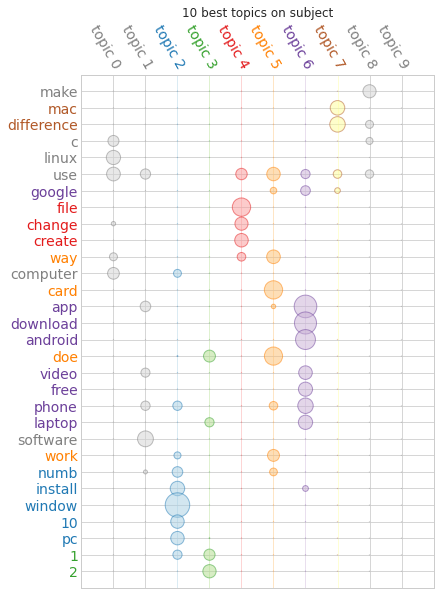

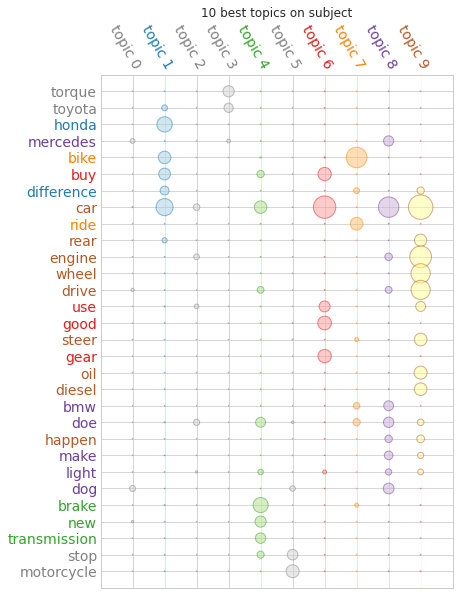

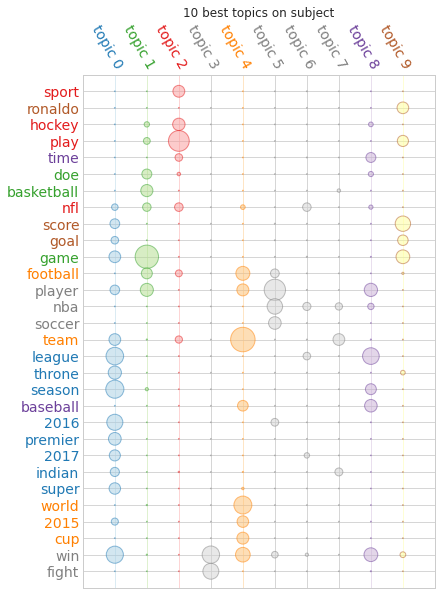

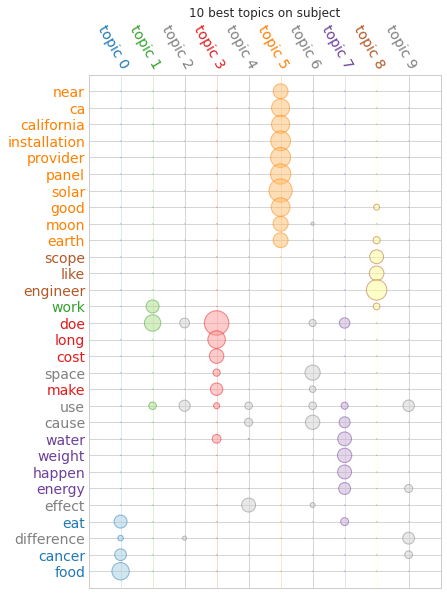

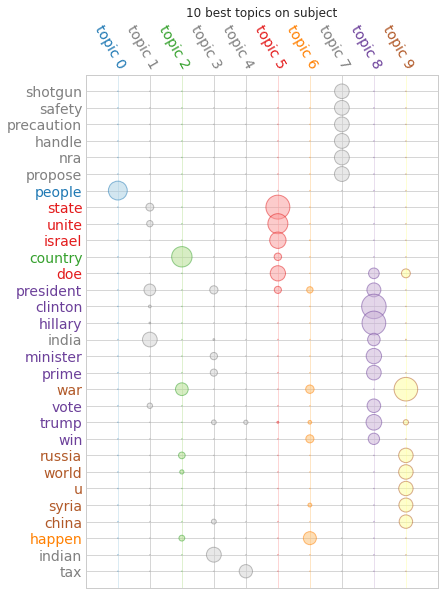

In [23]:
NEWSGROUP_LABELS=[
    'religion', #0
    'computers', #1
    'vehicles', #3
    'sport', #4
    'science', #5
    'politics' #6
]

for n in NEWSGROUP_LABELS:
    dataframe = train_dataframe[(train_dataframe['newsgroup_1']==n) & (train_dataframe['proba_newsgroup_1']>0.9)]['lemmatized_stopwords_question1']              
    textacy_lda_termite(dataframe,10,n,visu=True)

    

## Another (complex) way to display topics : Use t-distributed Stochastic Neighbor Embedding.

What exactly are we displaying ?

For each document:
* color is its dominant topic.
* position x,y is a projection of its vector of topics(10 dimensions) in a 2D with an exageration so that points are very disjoint

So we are looking distribution of question by topic and have a rude idea of how they are separable...

Smart, but we are stacking more and more complex processes and it becomes more and more difficult to interpret...

In [24]:

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors


# we get back to gensim LDA (Heavier than textacy but injecting its results in a tsne is 'easy')
def build_gensim_lda(dataframe,nb_topics):
    dictionary = corpora.Dictionary(dataframe.str.split())
    corpus = [dictionary.doc2bow(text) for text in dataframe.str.split()]
    tfidf = models.TfidfModel(corpus)
    transformed_tfidf = tfidf[corpus]
    start_model=time.time()
    return gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=nb_topics, 
            random_state=42,
            update_every=1,
            chunksize=1000,
            passes=10,
            per_word_topics=True)

def gensim_lda_tsne_bokeh(dataframe,nb_topics,subject):
    start = time.time()
    print_section('Gensim LDA on %s (%d questions) to find %d topics + tSNE + bokeh' % (subject,len(dataframe),nb_topics))
    print_info('Build gensim LDA')
    model = build_gensim_lda(dataframe,nb_topics)
    print_info('Build dictionary')
    dictionary = corpora.Dictionary(dataframe.str.split())
    print_info('Build corpus of vectors')
    corpus = [dictionary.doc2bow(text) for text in dataframe.str.split()]
    # Get topic weights
    topic_weights = []
    for i, row_list in enumerate(model[corpus]):
        topic_weights.append([w for i, w in row_list[0]])

    # Array of topic weights    
    arr = pandas.DataFrame(topic_weights).fillna(0).values
    # Keep the well separated points (optional)
    arr = arr[numpy.amax(arr, axis=1) > 0.35]

    # Dominant topic number in each doc
    topic_num = numpy.argmax(arr, axis=1)

    # tSNE Dimension Reduction
    print_info('tSNE Dimension Reduction')
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)

    # Plot the Topic Clusters using Bokeh
    print_info('Use Bokeh to generate a cool graph')
    output_notebook()
    n_topics = 10
    mycolors = numpy.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
    plot = figure(title="t-SNE Clustering of %d LDA Topics on %s" % (nb_topics,subject) ,
              plot_width=900, plot_height=700)
    plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
    print_done('Done',top=start)
    show(plot)

In [25]:
for n in NEWSGROUP_LABELS:
    dataframe = train_dataframe[(train_dataframe['newsgroup_1']==n) & (train_dataframe['proba_newsgroup_1']>0.9)]['lemmatized_stopwords_question1']              
    gensim_lda_tsne_bokeh(dataframe,10,n)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...